In [1]:
# Import the Google Drive module for Google Colab
from google.colab import drive

# Mount Google Drive at the desired directory
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define the project path where the dataset is stored, using the mounted path
project_path = '/content/drive/My Drive/Fake_Reviews_Detection'

In [3]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import string

# Suppress warnings to keep the output clean
warnings.filterwarnings('ignore')

# Import machine learning modules from sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Import nltk modules for text processing
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Set inline plotting for visualizations in Jupyter/Colab
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
# Load the preprocessed dataset into a DataFrame
data_path = project_path + '/Preprocessed_Home_Appliances_Reviews.csv'
df = pd.read_csv(data_path)

# Display the first few rows of the dataset to verify
df.head()

,Unnamed: 0,category,rating,label,text_
0,0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort love pretti
1,1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin 've mine coupl year
2,2,Home_and_Kitchen_5,5.0,CG,pillow save back love look feel pillow
3,3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price
4,4,Home_and_Kitchen_5,5.0,CG,nice set good qualiti set two month


In [5]:
# Remove the 'Unnamed: 0' column from the DataFrame if it exists
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
# Display the first 5 rows of the DataFrame
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort love pretti
1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin 've mine coupl year
2,Home_and_Kitchen_5,5.0,CG,pillow save back love look feel pillow
3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price
4,Home_and_Kitchen_5,5.0,CG,nice set good qualiti set two month


In [7]:
# Remove rows with missing values from the DataFrame
df = df[df.notna().all(axis=1)]

In [8]:
# Create a new column 'length' that contains the length of the text in 'text_'
df['length'] = df['text_'].str.len()

In [9]:
# Display the first 5 rows of the modified DataFrame
df.head()

,category,rating,label,text_,length
0,Home_and_Kitchen_5,5.0,CG,love well made sturdi comfort love pretti,41
1,Home_and_Kitchen_5,5.0,CG,love great upgrad origin 've mine coupl year,44
2,Home_and_Kitchen_5,5.0,CG,pillow save back love look feel pillow,38
3,Home_and_Kitchen_5,1.0,CG,miss inform use great product price,35
4,Home_and_Kitchen_5,5.0,CG,nice set good qualiti set two month,35


In [10]:
# Get a concise summary of the DataFrame
print(df.describe(include='all'))

              category        rating  label  \
count            40431  40431.000000  40431   
unique              10           NaN      2   
top     Kindle_Store_5           NaN     OR   
freq              4730           NaN  20216   
mean               NaN      4.256585    NaN   
std                NaN      1.144367    NaN   
min                NaN      1.000000    NaN   
25%                NaN      4.000000    NaN   
50%                NaN      5.000000    NaN   
75%                NaN      5.000000    NaN   
max                NaN      5.000000    NaN   

                                       text_        length  
count                                  40431  40431.000000  
unique                                 40380           NaN  
top     dog love kept occupi long time chase           NaN  
freq                                       5           NaN  
mean                                     NaN    189.695283  
std                                      NaN    205.553004  
min     

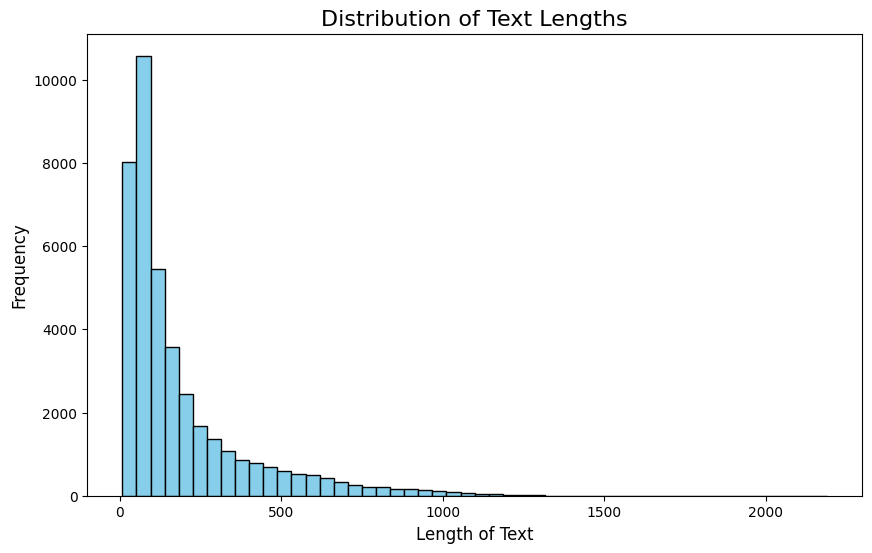

In [11]:
# Plot a histogram of the 'length' column with 50 bins
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(df['length'], bins=50, color='skyblue', edgecolor='black')
ax.set_title('Distribution of Text Lengths', fontsize=16)
ax.set_xlabel('Length of Text', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

In [12]:
# Group the DataFrame by 'label' and calculate summary statistics only for numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns
summary_stats = df.groupby('label')[numeric_columns].agg(['mean', 'std', 'min', 'max', 'count'])
print(summary_stats)

         rating                                 length                        \
           mean       std  min  max  count        mean         std min   max   
label                                                                          
CG     4.259906  1.141092  1.0  5.0  20215  156.631264  158.234489   9  1198   
OR     4.253265  1.147652  1.0  5.0  20216  222.757667  239.333983   8  2190   

              
       count  
label         
CG     20215  
OR     20216  


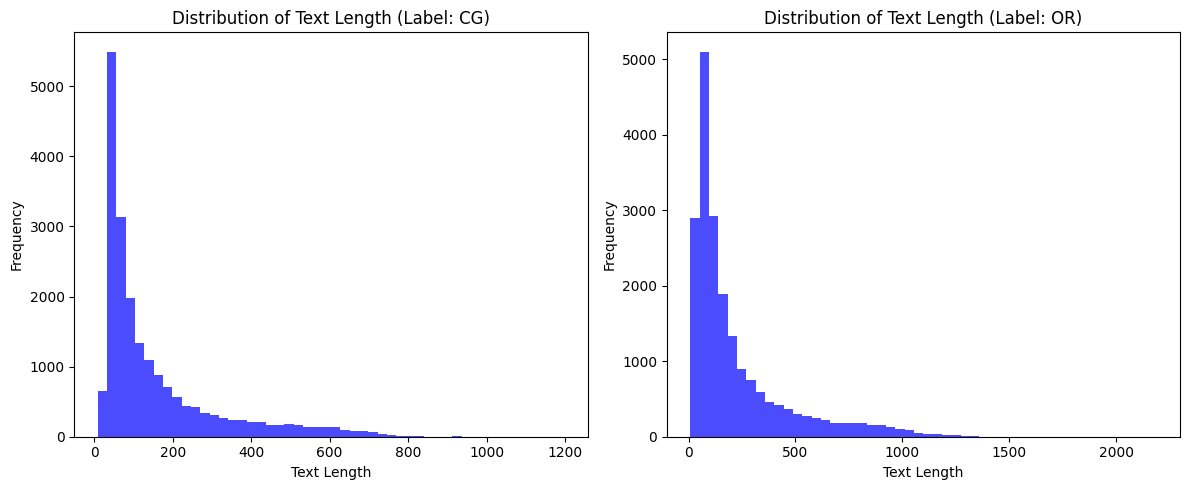

In [13]:
# Create two separate plots for each label
labels = df['label'].unique()  # Get the unique labels in the 'label' column

# Set up subplots to plot each histogram separately
fig, axes = plt.subplots(nrows=1, ncols=len(labels), figsize=(12,5))

# Loop through each label and plot the histogram
for i, label in enumerate(labels):
    ax = axes[i] if len(labels) > 1 else axes  # Handle case when there is only one label
    df[df['label'] == label]['length'].plot(kind='hist', bins=50, ax=ax, color='blue', alpha=0.7)
    ax.set_title(f'Distribution of Text Length (Label: {label})', fontsize=12)
    ax.set_xlabel('Text Length', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)

# Show the plots
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [14]:
# Get the text with the longest length from the 'OR' label
longest_text = df[df['label'] == 'OR'][['text_', 'length']] \
    .sort_values(by='length', ascending=False) \
    .iloc[0]['text_']

print(longest_text)


thought 'd purchas item also nbsp data-hook= '' product-link-link '' class= '' a-link-norm '' href= '' /kidco-door-knob-locks-clear-2-pack/dp/b0010cd2io/ref=cm_cr_arp_d_rvw_txt ie=utf8 '' kidco door knob lock clear pack /a nbsp nbsp data-hook= '' product-link-link '' class= '' a-link-norm '' href= '' /door-knob-lock/dp/b00238meqa/ref=cm_cr_arp_d_rvw_txt ie=utf8 '' door knob lock /a white color nbsp data-hook= '' product-link-link '' class= '' a-link-norm '' href= '' /kidco-door-knob-lock-colors-white/dp/b001j2wjf2/ref=cm_cr_arp_d_rvw_txt ie=utf8 '' kidco door knob lock color white /a nbsp nbsp data-hook= '' product-link-link '' class= '' a-link-norm '' href= '' /door-knob-lock-2-pack/dp/b00069bvgm/ref=cm_cr_arp_d_rvw_txt ie=utf8 '' door knob lock pack /a nbsp data-hook= '' product-link-link '' class= '' a-link-norm '' href= '' /secure-grip-clear-door-knob-covers-3-pack/dp/b00068xbxe/ref=cm_cr_arp_d_rvw_txt ie=utf8 '' secur grip clear door knob cover 3-pack /a nbsp compar two overal fun

In [15]:
# Get summary statistics for the 'length' column, including specific percentiles
length_summary = df['length'].describe().to_frame().T
length_summary.loc[:, '25%'] = df['length'].quantile(0.25)
length_summary.loc[:, '50%'] = df['length'].quantile(0.50)
length_summary.loc[:, '75%'] = df['length'].quantile(0.75)

print(length_summary)


          count        mean         std  min   25%    50%    75%     max
length  40431.0  189.695283  205.553004  8.0  58.0  106.0  232.0  2190.0


In [16]:
def process_text(review):
    # Remove punctuation from the review text
    cleaned_text = ''.join([char for char in review if char not in string.punctuation])

    # Split the text into words, convert to lowercase, and remove stopwords
    filtered_words = [word.lower() for word in cleaned_text.split() if word.lower() not in stopwords.words('english')]

    return filtered_words


In [17]:
# Initialize CountVectorizer with the custom text processing function
vectorizer = CountVectorizer(tokenizer=process_text)

# Display the vectorizer
print(vectorizer)


CountVectorizer(tokenizer=<function process_text at 0x783c29470dc0>)


In [18]:
# Fit the CountVectorizer to the text data and extract the vocabulary
vectorizer.fit(df['text_'])

# Print the size of the vocabulary
vocabulary_size = len(vectorizer.vocabulary_)
print(f"Total Vocabulary Size: {vocabulary_size}")


Total Vocabulary Size: 34450


In [19]:
# Extract the review text at index 3
sample_review = df['text_'].iloc[3]

# Display the review text
print(sample_review)


miss inform use great product price


In [20]:
# Transform the sample review using the fitted vectorizer
transformed_review = vectorizer.transform([sample_review])

# Display the transformed review and its shape
print(transformed_review)
print(f"Shape of the transformed review: {transformed_review.shape}")


  (0, 13595)	1
  (0, 15837)	1
  (0, 19846)	1
  (0, 23845)	1
  (0, 23975)	1
  (0, 32179)	1
Shape of the transformed review: (1, 34450)


In [21]:
# Get the words corresponding to the specified feature indices from the vocabulary
word_at_index_15837 = vectorizer.get_feature_names_out()[15837]
word_at_index_23845 = vectorizer.get_feature_names_out()[23845]

# Print the words
print(f"Word at index 15840: {word_at_index_15837}")
print(f"Word at index 23847: {word_at_index_23845}")


Word at index 15840: inform
Word at index 23847: price


In [22]:
# Transform the entire text data using the fitted vectorizer
vectorized_reviews = vectorizer.transform(df['text_'])

# Display the transformed review data
print(vectorized_reviews)


  (0, 7280)	1
  (0, 18374)	2
  (0, 18652)	1
  (0, 23822)	1
  (0, 29216)	1
  (0, 33201)	1
  (1, 7862)	1
  (1, 13595)	1
  (1, 18374)	1
  (1, 19706)	1
  (1, 21894)	1
  (1, 32098)	1
  (1, 34165)	1
  (2, 3723)	1
  (2, 11616)	1
  (2, 18278)	1
  (2, 18374)	1
  (2, 23093)	2
  (2, 26326)	1
  (3, 13595)	1
  (3, 15837)	1
  (3, 19846)	1
  (3, 23845)	1
  (3, 23975)	1
  (3, 32179)	1
  :	:
  (40430, 28447)	1
  (40430, 28741)	1
  (40430, 28921)	1
  (40430, 29380)	1
  (40430, 29509)	1
  (40430, 29802)	1
  (40430, 29852)	1
  (40430, 30345)	1
  (40430, 30366)	1
  (40430, 30371)	1
  (40430, 30432)	1
  (40430, 30478)	1
  (40430, 30596)	2
  (40430, 30720)	1
  (40430, 30802)	2
  (40430, 31590)	1
  (40430, 32179)	2
  (40430, 32885)	3
  (40430, 33074)	1
  (40430, 33117)	7
  (40430, 33148)	1
  (40430, 33683)	1
  (40430, 33803)	1
  (40430, 33806)	4
  (40430, 34230)	3


In [23]:
# Print the shape of the vectorized review data
print(f"Shape of the vectorized reviews corpus: {vectorized_reviews.shape}")

# Print the number of non-zero values in the vectorized review data
print(f"Number of non-zero entries in the vectorized reviews: {vectorized_reviews.nnz}")


Shape of the vectorized reviews corpus: (40431, 34450)
Number of non-zero entries in the vectorized reviews: 1001193


In [24]:
# Calculate and print the sparsity of the vectorized review data
sparsity = np.round((vectorized_reviews.nnz / (vectorized_reviews.shape[0] * vectorized_reviews.shape[1])) * 100, 2)
print(f"Sparsity of the vectorized review data: {sparsity}%")


Sparsity of the vectorized review data: 0.07%


In [25]:
# Initialize and fit the TF-IDF transformer to the vectorized review data
tfidf_vectorizer = TfidfTransformer().fit(vectorized_reviews)

# Transform the sample review using the fitted TF-IDF transformer
tfidf_sample_review = tfidf_vectorizer.transform(transformed_review)

# Print the transformed sample review
print(tfidf_sample_review)


  (0, 13595)	0.22849485246633358
  (0, 15837)	0.5617597836165477
  (0, 19846)	0.5603228913884096
  (0, 23845)	0.3623513042969684
  (0, 23975)	0.34242957418905806
  (0, 32179)	0.2640034550694301


In [26]:
# Print the inverse document frequency (IDF) for the terms 'mango' and 'book'
idf_mango = tfidf_vectorizer.idf_[vectorizer.vocabulary_['mango']]
idf_book = tfidf_vectorizer.idf_[vectorizer.vocabulary_['book']]

# Output the IDF values for both terms
print(f"IDF for 'mango': {idf_mango}")
print(f"IDF for 'book': {idf_book}")


IDF for 'mango': 10.91422964906803
IDF for 'book': 2.821684385176731


In [27]:
# Transform the entire vectorized reviews data using the fitted TF-IDF transformer
tfidf_reviews = tfidf_vectorizer.transform(vectorized_reviews)

# Output the shape and number of dimensions of the transformed data
print(f"Shape of TF-IDF transformed reviews: {tfidf_reviews.shape}")
print(f"Number of dimensions of the transformed data: {tfidf_reviews.ndim}")


Shape of TF-IDF transformed reviews: (40431, 34450)
Number of dimensions of the transformed data: 2


## Creating Training and Test Data

In [28]:
# Split the dataset into training and testing sets
train_texts, test_texts, train_labels, test_labels = train_test_split(df['text_'], df['label'], test_size=0.25)

# Display the shape of the training and test sets
print(f"Training data size: {train_texts.shape}")
print(f"Testing data size: {test_texts.shape}")


Training data size: (30323,)
Testing data size: (10108,)


In [29]:
# Create a pipeline with CountVectorizer, TF-IDF transformer, and RandomForestClassifier
model_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer=process_text)),
    ('tfidf_transformer', TfidfTransformer()),
    ('classifier', RandomForestClassifier())
])


In [30]:
# Train the pipeline on the training data
model_pipeline.fit(train_texts, train_labels)


Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function process_text at 0x783c29470dc0>)),
                ('tfidf_transformer', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

In [31]:
# Use the trained pipeline to make predictions on the test data using Random Forest classifier
rf_predictions = model_pipeline.predict(test_texts)

# Output the predictions
print("Predictions by Random Forest Classifier:", rf_predictions)


Predictions by Random Forest Classifier: ['OR' 'OR' 'CG' ... 'CG' 'CG' 'CG']


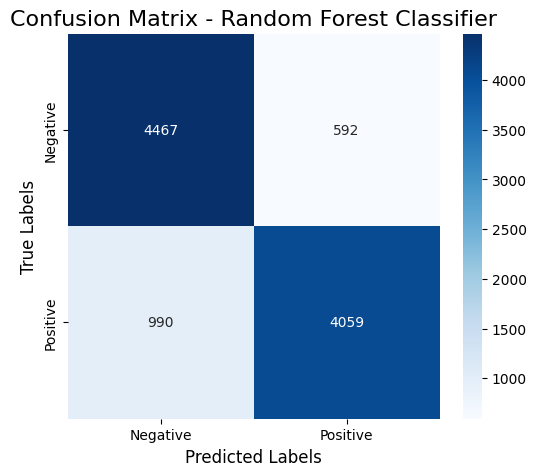

Classification Report:               precision    recall  f1-score   support

          CG       0.82      0.88      0.85      5059
          OR       0.87      0.80      0.84      5049

    accuracy                           0.84     10108
   macro avg       0.85      0.84      0.84     10108
weighted avg       0.85      0.84      0.84     10108

Accuracy Score: 0.8434903047091413
Model Prediction Accuracy: 84.35%


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, rf_predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Random Forest Classifier', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()


# Classification report and accuracy score
print('Classification Report:', classification_report(test_labels, rf_predictions))

# Accuracy score
rf_accuracy = accuracy_score(test_labels, rf_predictions)
print('Accuracy Score:', rf_accuracy)

# Model prediction accuracy in percentage
print(f'Model Prediction Accuracy: {np.round(rf_accuracy * 100, 2)}%')

In [33]:
# Create a pipeline with CountVectorizer, TF-IDF transformer, and Support Vector Classifier (SVC)
model_pipeline_svc = Pipeline([
    ('vectorizer', CountVectorizer(analyzer=process_text)),
    ('tfidf_transformer', TfidfTransformer()),
    ('svm_classifier', SVC())
])


In [34]:
# Train the model pipeline using Support Vector Classifier (SVC) on the training data
model_pipeline_svc.fit(train_texts, train_labels)


Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function process_text at 0x783c29470dc0>)),
                ('tfidf_transformer', TfidfTransformer()),
                ('svm_classifier', SVC())])

In [35]:
# Use the trained SVC pipeline to make predictions on the test data
svm_predictions = model_pipeline_svc.predict(test_texts)

# Output the predictions
print("Predictions by Support Vector Classifier (SVC):", svm_predictions)


Predictions by Support Vector Classifier (SVC): ['OR' 'CG' 'CG' ... 'OR' 'CG' 'CG']


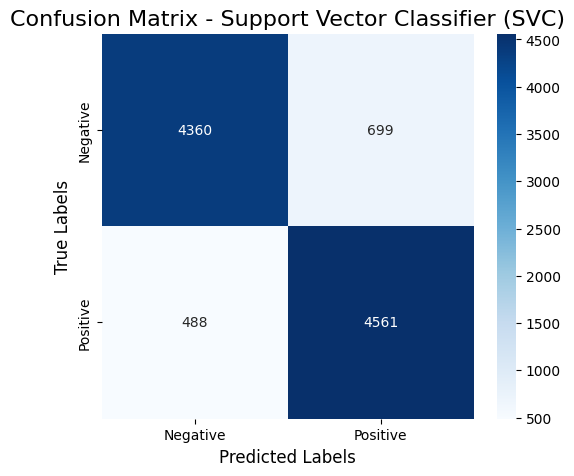

Classification Report:               precision    recall  f1-score   support

          CG       0.90      0.86      0.88      5059
          OR       0.87      0.90      0.88      5049

    accuracy                           0.88     10108
   macro avg       0.88      0.88      0.88     10108
weighted avg       0.88      0.88      0.88     10108

Accuracy Score: 0.8825682627621686
Model Prediction Accuracy: 88.26%


In [36]:
# Generate the confusion matrix
conf_matrix_svc = confusion_matrix(test_labels, svm_predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_svc, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Support Vector Classifier (SVC)', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

# Classification report
print('Classification Report:', classification_report(test_labels, svm_predictions))

# Accuracy score
svc_accuracy = accuracy_score(test_labels, svm_predictions)
print('Accuracy Score:', svc_accuracy)

# Model prediction accuracy in percentage
print(f'Model Prediction Accuracy: {np.round(svc_accuracy * 100, 2)}%')


In [37]:
# Create a pipeline with CountVectorizer, TF-IDF transformer, and Logistic Regression classifier
logistic_regression_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(analyzer=process_text)),
    ('tfidf_transformer', TfidfTransformer()),
    ('lr_classifier', LogisticRegression())
])


In [38]:
# Train the logistic regression pipeline on the training data
logistic_regression_pipeline.fit(train_texts, train_labels)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(analyzer=<function process_text at 0x783c29470dc0>)),
                ('tfidf_transformer', TfidfTransformer()),
                ('lr_classifier', LogisticRegression())])

In [39]:
# Use the trained logistic regression pipeline to make predictions on the test data
lr_predictions = logistic_regression_pipeline.predict(test_texts)

# Output the predictions
print("Predictions by Logistic Regression:", lr_predictions)


Predictions by Logistic Regression: ['OR' 'CG' 'CG' ... 'OR' 'CG' 'CG']


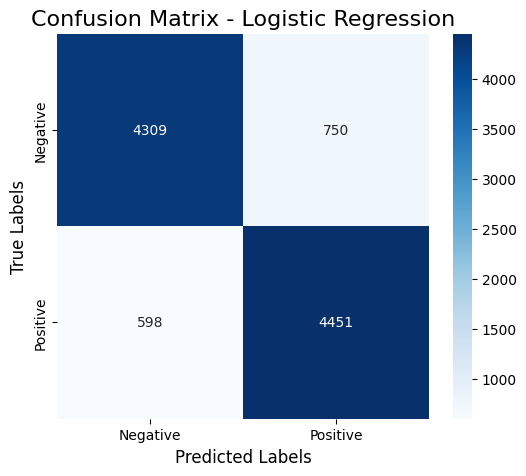

Classification Report:               precision    recall  f1-score   support

          CG       0.88      0.85      0.86      5059
          OR       0.86      0.88      0.87      5049

    accuracy                           0.87     10108
   macro avg       0.87      0.87      0.87     10108
weighted avg       0.87      0.87      0.87     10108

Accuracy Score: 0.8666402849228334
Model Prediction Accuracy: 86.66%


In [40]:
# Generate the confusion matrix
conf_matrix_lr = confusion_matrix(test_labels, lr_predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Logistic Regression', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.show()

# Classification report for Logistic Regression
print('Classification Report:', classification_report(test_labels, lr_predictions))

# Accuracy score of the Logistic Regression model
lr_accuracy = accuracy_score(test_labels, lr_predictions)
print('Accuracy Score:', lr_accuracy)

# Model prediction accuracy as a percentage
print(f'Model Prediction Accuracy: {np.round(lr_accuracy * 100, 2)}%')


## Conclusion

In [41]:
# Print the performance of various ML models
print('Performance of Various Machine Learning Models:')
print('-' * 50)  # Adds a separator line for clarity
print(f'Random Forest Classifier Prediction Accuracy: {np.round(accuracy_score(test_labels, rf_predictions) * 100, 2)}%')
print(f'Support Vector Machines Prediction Accuracy: {np.round(accuracy_score(test_labels, svm_predictions) * 100, 2)}%')
print(f'Logistic Regression Prediction Accuracy: {np.round(accuracy_score(test_labels, lr_predictions) * 100, 2)}%')
print('-' * 50)  # Adds a separator line after the results

Performance of Various Machine Learning Models:
--------------------------------------------------
Random Forest Classifier Prediction Accuracy: 84.35%
Support Vector Machines Prediction Accuracy: 88.26%
Logistic Regression Prediction Accuracy: 86.66%
--------------------------------------------------
